You can choose to upload the Kaggle API token to download the data, download it manually and upload it to this Colab instance, or simply download it from a Google Drive link using gdown, you can choose to run either one.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"x4nth055","key":"adbc7e82e1f942409db4f38a99aacdc6"}'}

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c fake-news

  0% 0.00/40.6k [00:00<?, ?B/s]
100% 40.6k/40.6k [00:00<00:00, 67.7MB/s]
 73% 27.0M/37.0M [00:00<00:00, 45.9MB/s]
100% 37.0M/37.0M [00:00<00:00, 119MB/s] 
 53% 5.00M/9.42M [00:00<00:00, 41.7MB/s]
100% 9.42M/9.42M [00:00<00:00, 52.2MB/s]


In [ ]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!pip install gdown

In [ ]:
# download from Google Drive
!gdown "https://drive.google.com/uc?id=178f_VkNxccNidap-5-uffXUW475pAuPy&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=178f_VkNxccNidap-5-uffXUW475pAuPy&confirm=t
To: /content/fake-news.zip
100% 48.7M/48.7M [00:00<00:00, 74.6MB/s]


In [ ]:
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
### Import all library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# load the dataset
news_d = pd.read_csv("train.csv")
submit_test = pd.read_csv("test.csv")

In [ ]:
## Shape and colums of train dataset
print(" Shape of News data :: ", news_d.shape)
print(" News data columns", news_d.columns)

 Shape of News data ::  (20800, 5)
 News data columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [ ]:
## by using df.head(),We can immediately familiarize ourselves with the dataset. 
news_d.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
#Text Word startistics: min.mean, max and interquartile range

txt_length = news_d.text.str.split().str.len()
txt_length.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [ ]:
#Title statistics 

title_length = news_d.title.str.split().str.len()
title_length.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

1: Unreliable
0: Reliable
Distribution of labels:
1    10413
0    10387
Name: label, dtype: int64


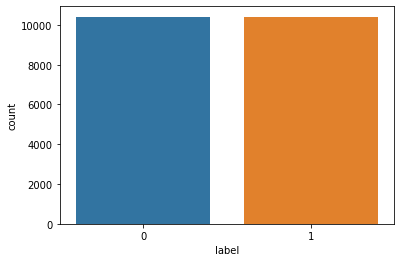

In [ ]:
sns.countplot(x="label", data=news_d);
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(news_d.label.value_counts());


In [ ]:
print(round(news_d.label.value_counts(normalize=True),2)*100);

1    50.0
0    50.0
Name: label, dtype: float64


In [ ]:
# Constants that are used to sanitize the datasets 
column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

In [ ]:
# Clean Datasets
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [ ]:
# Perform data cleaning on train and test dataset by calling clean_dataset function
df = clean_dataset(news_d)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df["text"] = df.text.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
df["title"] = df.title.apply(nltk_preprocess)

In [ ]:
# Dataset after cleaning and preprocessing step
df.head()

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


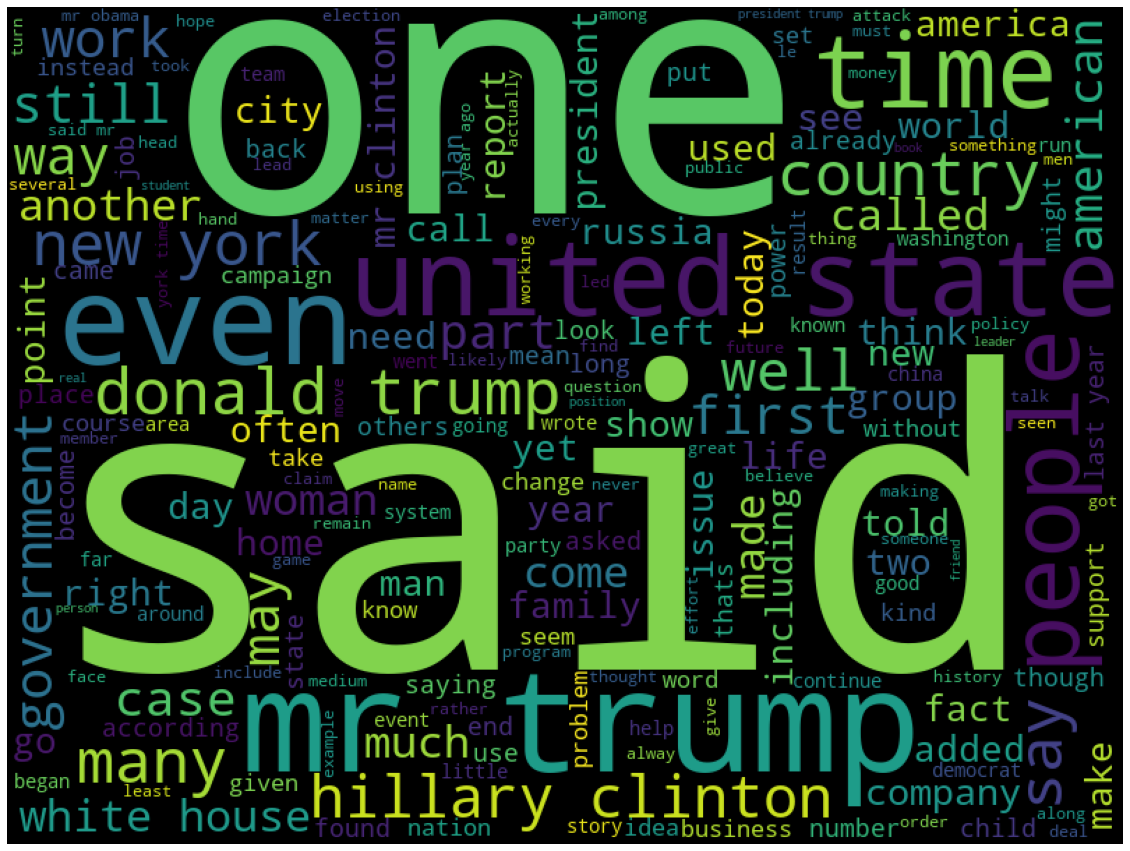

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# initialize the word cloud
wordcloud = WordCloud( background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(df['text']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

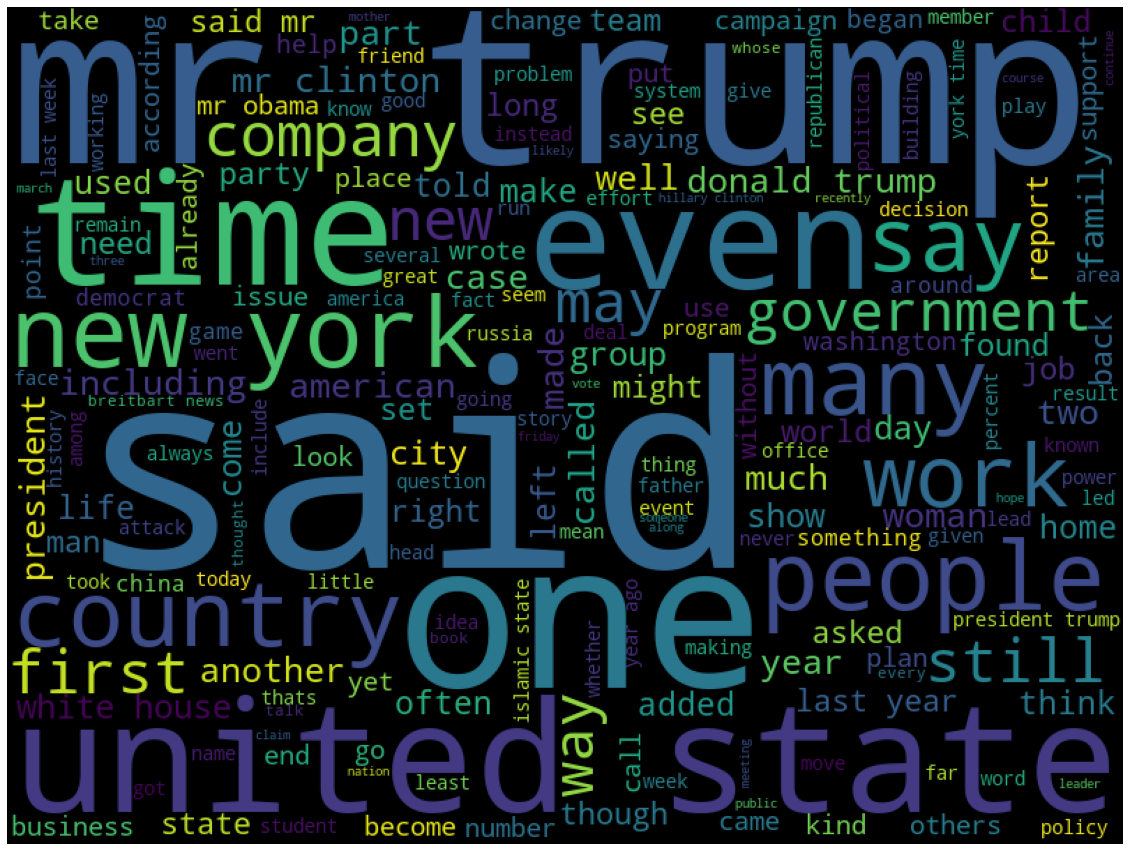

In [ ]:
true_n = ' '.join(df[df['label']==0]['text']) 
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

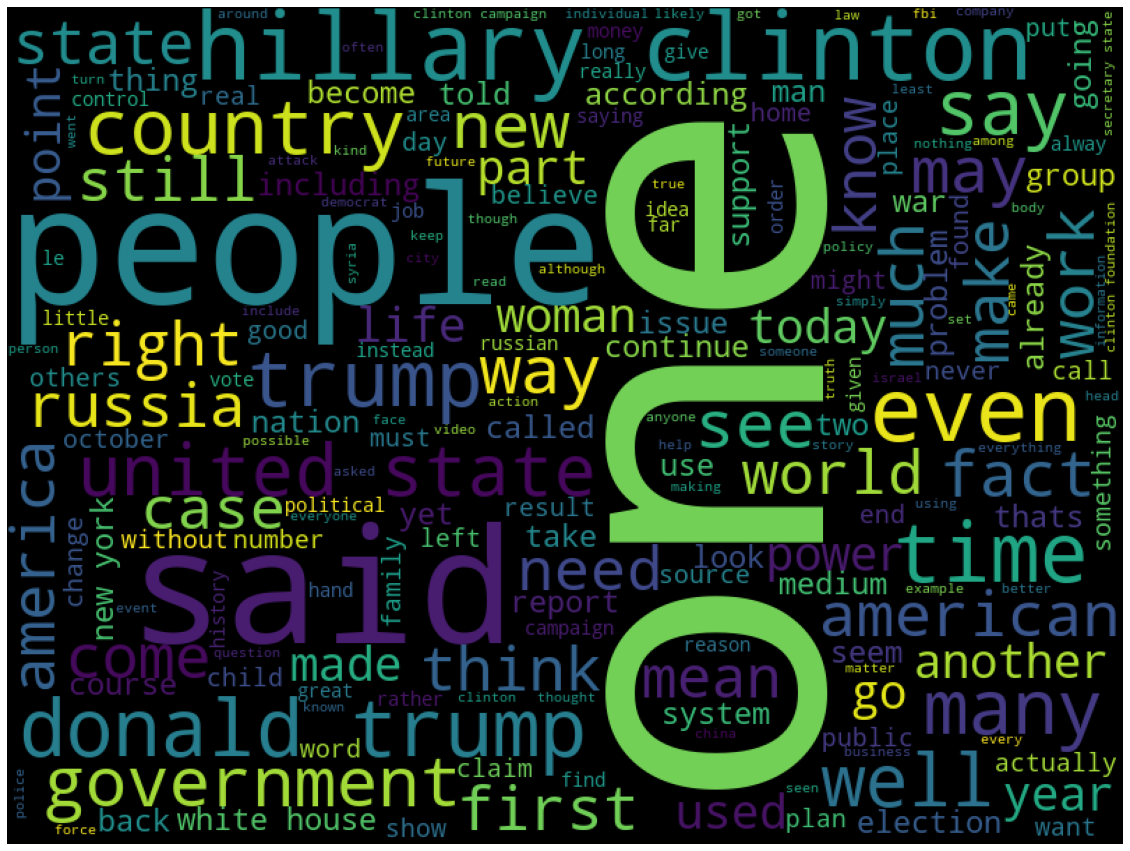

In [ ]:
fake_n = ' '.join(df[df['label']==1]['text'])
wc= wordcloud.generate(fake_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurences", n=2):
  """Utility function to plot top n-grams"""
  true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
  true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()

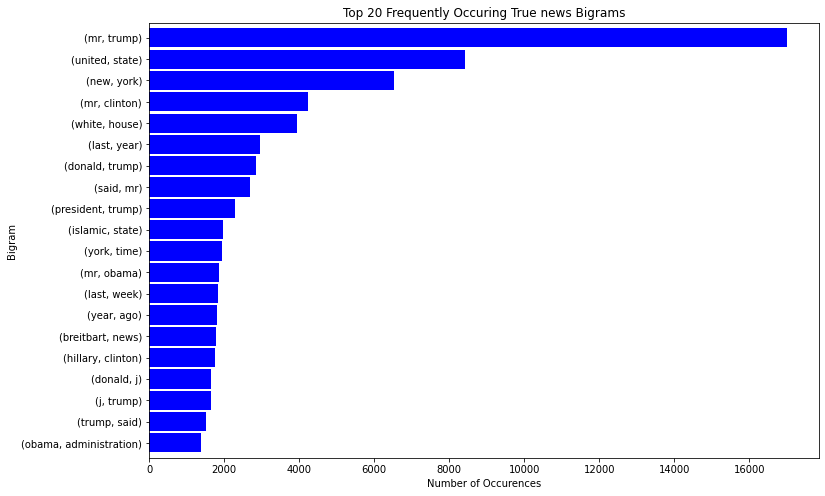

In [ ]:
plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Bigrams', "Bigram", n=2)

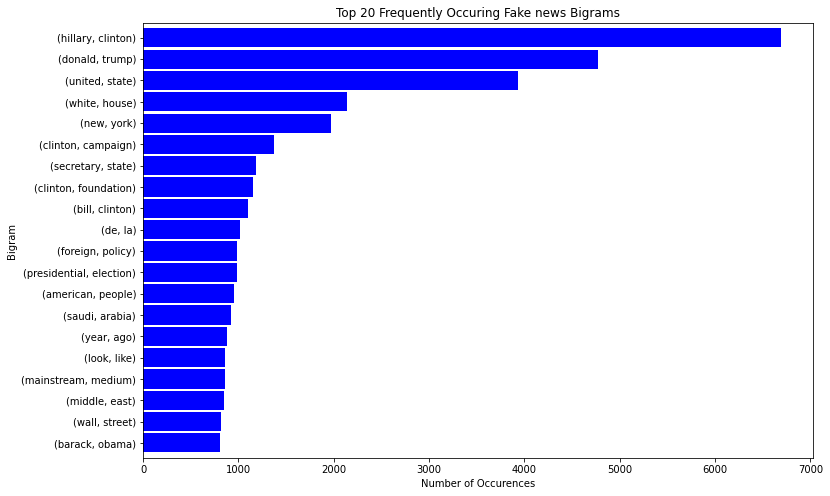

In [ ]:
plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)

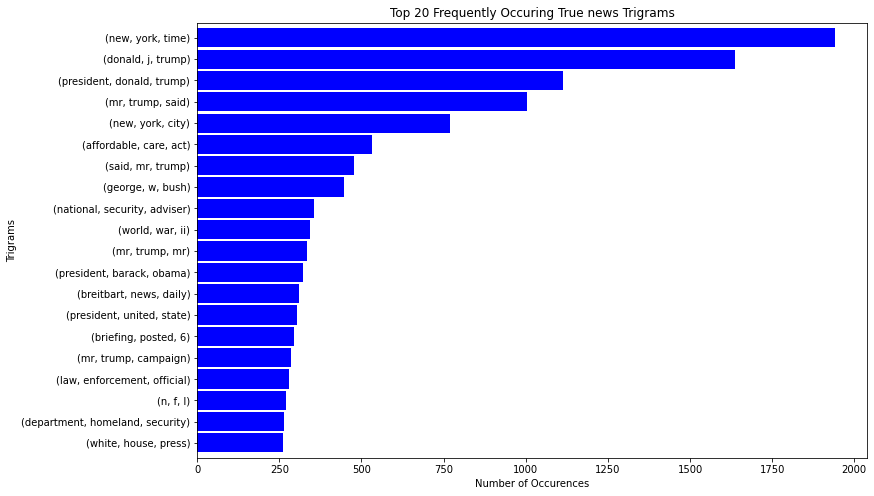

In [ ]:
plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Trigrams', "Trigrams", n=3)

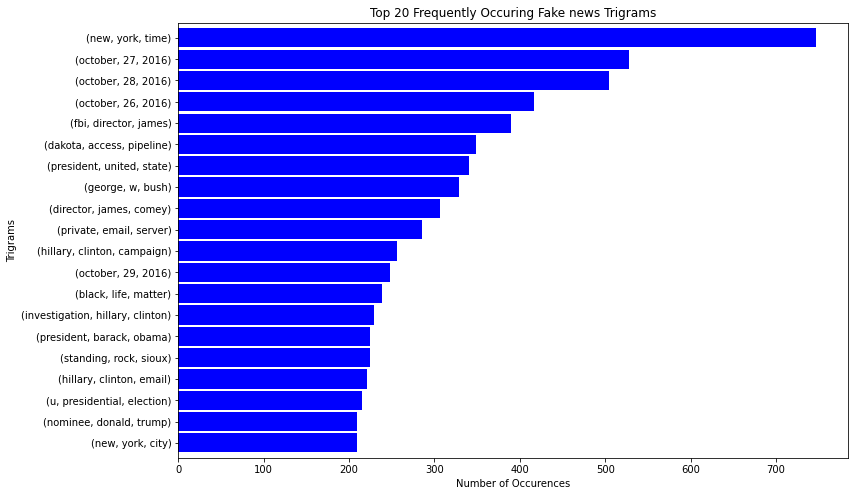

In [ ]:
plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Trigrams', "Trigrams", n=3)

# Fine-tuning BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 895 kB 68.2 MB/s 
     |████████████████████████████████| 6.8 MB 47.8 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random

In [ ]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

In [ ]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [ ]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
news_df = news_d[news_d['text'].notna()]
news_df = news_df[news_df["author"].notna()]
news_df = news_df[news_df["title"].notna()]

In [ ]:
def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
  texts = []
  labels = []
  for i in range(len(df)):
    text = df["text"].iloc[i]
    label = df["label"].iloc[i]
    if include_title:
      text = df["title"].iloc[i] + " - " + text
    if include_author:
      text = df["author"].iloc[i] + " : " + text
    if text and label in [0, 1]:
      texts.append(text)
      labels.append(label)
  return train_test_split(texts, labels, test_size=test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(news_df)

In [ ]:
print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

14628 14628
3657 3657


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [ ]:
# load the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14628
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 1463


Step,Training Loss,Validation Loss,Accuracy
200,0.250800,0.100533,0.983867
400,0.027600,0.043009,0.993437
600,0.023400,0.017812,0.997539
800,0.014900,0.030269,0.994258
1000,0.022400,0.012961,0.998086
1200,0.009800,0.010561,0.998633
1400,0.007700,0.010300,0.998633


***** Running Evaluation *****
  Num examples = 3657
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3657
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3657
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3657
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
****

TrainOutput(global_step=1463, training_loss=0.04888018785440506, metrics={'train_runtime': 2469.1722, 'train_samples_per_second': 5.924, 'train_steps_per_second': 0.593, 'total_flos': 3848788517806080.0, 'train_loss': 0.04888018785440506, 'epoch': 1.0})

In [ ]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3657
  Batch size = 20


{'epoch': 1.0,
 'eval_accuracy': 0.998632759092152,
 'eval_loss': 0.010299865156412125,
 'eval_runtime': 132.0374,
 'eval_samples_per_second': 27.697,
 'eval_steps_per_second': 1.386}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in fake-news-bert-base-uncased/config.json
Model weights saved in fake-news-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in fake-news-bert-base-uncased/tokenizer_config.json
Special tokens file saved in fake-news-bert-base-uncased/special_tokens_map.json


('fake-news-bert-base-uncased/tokenizer_config.json',
 'fake-news-bert-base-uncased/special_tokens_map.json',
 'fake-news-bert-base-uncased/vocab.txt',
 'fake-news-bert-base-uncased/added_tokens.json',
 'fake-news-bert-base-uncased/tokenizer.json')

In [ ]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "reliable",
        1: "fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [ ]:
real_news = """
Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman   quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. He will hold a workout for M. L. B. teams this month, his agents told ESPN and other news outlets. “This may sound like a publicity stunt, but nothing could be further from the truth,” said Brodie Van Wagenen,   of CAA Baseball, part of the sports agency CAA Sports, in the statement. “I have seen Tim’s workouts, and people inside and outside the industry  —   scouts, executives, players and fans  —   will be impressed by his talent. ” It’s been over a decade since Tebow, 28, has played baseball full time, which means a comeback would be no easy task. But the former major league catcher Chad Moeller, who said in the statement that he had been training Tebow in Arizona, said he was “beyond impressed with Tim’s athleticism and swing. ” “I see bat speed and power and real baseball talent,” Moeller said. “I truly believe Tim has the skill set and potential to achieve his goal of playing in the major leagues and based on what I have seen over the past two months, it could happen relatively quickly. ” Or, take it from Gary Sheffield, the former   outfielder. News of Tebow’s attempted comeback in baseball was greeted with skepticism on Twitter. As a junior at Nease High in Ponte Vedra, Fla. Tebow drew the attention of major league scouts, batting . 494 with four home runs as a left fielder. But he ditched the bat and glove in favor of pigskin, leading Florida to two national championships, in 2007 and 2009. Two former scouts for the Los Angeles Angels told WEEI, a Boston radio station, that Tebow had been under consideration as a high school junior. “’x80’x9cWe wanted to draft him, ’x80’x9cbut he never sent back his information card,” said one of the scouts, Tom Kotchman, referring to a questionnaire the team had sent him. “He had a strong arm and had a lot of power,” said the other scout, Stephen Hargett. “If he would have been there his senior year he definitely would have had a good chance to be drafted. ” “It was just easy for him,” Hargett added. “You thought, If this guy dedicated everything to baseball like he did to football how good could he be?” Tebow’s high school baseball coach, Greg Mullins, told The Sporting News in 2013 that he believed Tebow could have made the major leagues. “He was the leader of the team with his passion, his fire and his energy,” Mullins said. “He loved to play baseball, too. He just had a bigger fire for football. ” Tebow wouldn’t be the first athlete to switch from the N. F. L. to M. L. B. Bo Jackson had one   season as a Kansas City Royal, and Deion Sanders played several years for the Atlanta Braves with mixed success. Though Michael Jordan tried to cross over to baseball from basketball as a    in 1994, he did not fare as well playing one year for a Chicago White Sox minor league team. As a football player, Tebow was unable to match his college success in the pros. The Denver Broncos drafted him in the first round of the 2010 N. F. L. Draft, and he quickly developed a reputation for clutch performances, including a memorable   pass against the Pittsburgh Steelers in the 2011 Wild Card round. But his stats and his passing form weren’t pretty, and he spent just two years in Denver before moving to the Jets in 2012, where he spent his last season on an N. F. L. roster. He was cut during preseason from the New England Patriots in 2013 and from the Philadelphia Eagles in 2015.
"""

In [ ]:
get_prediction(real_news, convert_to_label=True)

0

In [ ]:
# read the test set
test_df = pd.read_csv("test.csv")

In [ ]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
# make a copy of the testing set
new_df = test_df.copy()

In [ ]:
# add a new column that contains the author, title and article content
new_df["new_text"] = new_df["author"].astype(str) + " : " + new_df["title"].astype(str) + " - " + new_df["text"].astype(str)
new_df.head()

,id,title,author,text,new_text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",David Streitfeld : Specter of Trump Loosens To...
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,nan : Russian warships ready to strike terrori...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,Common Dreams : #NoDAPL: Native American Leade...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",Daniel Victor : Tim Tebow Will Attempt Another...
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Truth Broadcast Network : Keiser Report: Meme ...


In [ ]:
# get the prediction of all the test set
new_df["label"] = new_df["new_text"].apply(get_prediction)

In [ ]:
# make the submission file
final_df = new_df[["id", "label"]]
final_df.to_csv("submit_final.csv", index=False)